# Unmasking the Face: Emotion detection using Machine Learning 

#### By Maria Gil Rodriguez

## 1. Introduction

It is a well-known fact that human beings are responsible for the depiction of six basic emotions: **happiness, anger, surprise, sadness, fear**, and **disgust**. Creating a model that can accurately classify these emotions can be extremely useful in a variety of areas such as image processing, cybersecurity, robotics, psychological studies, virtual reality applications, etc. 

The **main objective** of this capstone is to categorize faces based on the emotion shown in the expression into one of seven categories (the six basic emotions plus one category for neutral).

The model developed will be able to predict the facial emotion on pictures. Some real-world examples for this application are: 
* Determining client’s medical state;
* During healthcare treatments, determining the patients feeling and comfort level;
* In the case of autism, helping to interpret expressions;
* In e-learning, adjusting the learning technique according to the style of learner; 
* In the case of driving, determining fatigue and alerting in advance; 


To achieve this, in this capstone we will:
* Explore the creation of features with unsupervised techniques: PCA and LBP
* Use those features to run supervised learning classification models: Random forest, Gradient Bossting and SVC
* Use pretrained CNNs for the classification
* Create our own CNN and compare the results
* Explore the feature extraction from these CNN
* Save the model to test it with pictures from the test set and our own pictures

For the CNN part, we will use the fastai library that sits on top of PyTorch.


## 2. The Dataset

The data we will be using is part of a Kaggle competition. It consists of **48x48 pixel grayscale images** of faces and can be found in:
https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data. 

As we will see later, it consists on a .csv file with the class (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral), the usage (training, validation or test set), and an array with the values of the pixels.

However, for ease to use, when working with the fast.ai library, we are going to use this other version of the exact same dataset, were the images are .jpg files in folders:
https://www.kaggle.com/aspiring1/fer2013-images

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from collections import Counter
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import decomposition
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.widgets import *
from fastai.callbacks.hooks import *
current_palette = sns.color_palette('GnBu_d',7)
sns.set_palette(current_palette)

We have three sets of data: Training, PublicTest and PrivateTest. However, we have notice that PublicTest, the one we would use for validation, is quite messy with missing images and wrong labels. Thus we will split Training in two (80%/20%) and we will use PrivateTest, which has no labels, as out test set.

In [2]:
# Indicate the paths for the two datasets (.csv and images)
path = '../input/fer2013-images/images/images_fer2013/Training'
path2 = '../input/challenges-in-representation-learning-facial-expression-recognition-challenge/fer2013/fer2013/fer2013.csv'
wd = '/kaggle/working' # Create a working directory to save files created

# Create ImageDataBunch (from fastai library)  
bs=128
np.random.seed(42)
tfms = get_transforms(max_rotate=20, max_zoom=1.1, max_lighting=0.4, max_warp=0.2, p_affine=1., p_lighting=1.1) #no transforms in valid set                      
data = ImageDataBunch.from_folder(path, train='.', valid_pct=.2, 
                                  test='../PrivateTest/', 
                                  ds_tfms=tfms, bs=bs)
data.normalize(imagenet_stats)

print(f'Number of images:\nTraining: {len(data.train_ds)}, Validation: {len(data.valid_ds)}, Test {len(data.test_ds)}')

Number of images:
Training: 22968, Validation: 5741, Test 3589


And, for each set, we have the following classes.

In [3]:
classes = data.classes
print(classes)

['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Let's see some examples of images:

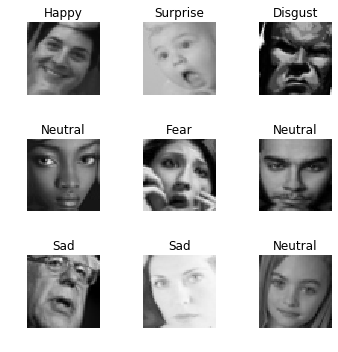

In [4]:
data.show_batch(rows=3, figsize=(5,5))

### *Analysis of the data*

Let's load the .cvs file and look at the data. 

We are going to do a little cleaning, removing duplicates if they exist.

In [5]:
# Load .csv file and remove duplicates
df_raw = pd.read_csv(path2)
df_raw.drop_duplicates(subset='pixels', keep = False, inplace = True) 
df_raw.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


Let's see how many images of each class we have in our training set.

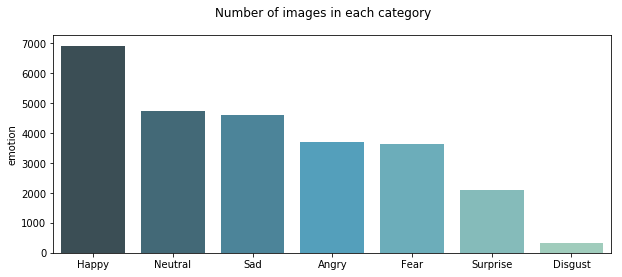

In [6]:
plt.figure(figsize=(10,4))
labels = ['Happy', 'Neutral', 'Sad', 'Angry', 'Fear','Surprise', 'Disgust']
plt.suptitle('Number of images in each category')
sns.barplot(labels, df_raw[df_raw['Usage'] == 'Training'].emotion.value_counts())
plt.show()

We clearly have class imbalance, which is especially pronounce in the category 'Disgust'.

## 3. Classic Supervised Learning Models and Feature Extraction



### *Pre-processing*

Before applying our models, let's keep only the class (emotion) and the pixel values.

In [7]:
# Pixels in array 
df_raw['pixels'] = df_raw['pixels'].apply(lambda im: np.fromstring(im, sep=' '))

# Separate train and validation set
df = df_raw[['emotion', 'pixels']][df_raw['Usage'] == 'Training']
df.head()

,emotion,pixels
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63...."
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111..."
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161..."
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20...."
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


To avoid the class imbalance, but also (and mostly), because the models we are going to use in this part would take a long time to run in +28K images, we are going to select only 100 images of each class for the training set and 50 in the validation set.

To do that, we will first shuffle the dataframe and then split it, getting the right amount of images from each class.

In [8]:
# Create empty dataframes
df_train = pd.DataFrame()
df_valid = pd.DataFrame()


# Shuffle and split
random.seed(42)
df = shuffle(df, random_state=42)
for i in range(7):
    df_train = df_train.append(df[df.emotion == i][0:100])
    df_valid = df_valid.append(df[df.emotion == i][100:150])

We can now separate the train and validation set in X and y.

In [9]:
# Scale and define train and valid X and y
X_train = np.vstack(df_train['pixels'].values)/255 # Is this correct?
y_train = np.array(df_train['emotion'])

X_valid = np.vstack(df_valid['pixels'].values)/255 
y_valid = np.array(df_valid['emotion'])

Let's take a look on the number of elements of each class in both the training and validation set to make sure everything worked.

In [10]:
print('Train: ', X_train.shape)
print('Valid: ', X_valid.shape)

Train:  (700, 2304)
Valid:  (350, 2304)


### * Models*

We will be running Random Forest, Gradient Boosting and SVC in different scenarios. All the models will be tuned with GridSearchCV to get the optimum hyperparameters.

Let's fist run the three models in our reduced dataset without further transformations.

In [11]:
# Define a function to print the models' results
classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
def print_results(model, X_train, X_valid, y_pred):
    print('Train set score:\t\t', round(model.score(X_train, y_train),2))
    print('Best cross validation score:\t', round(model.best_score_,2))
    print('Validation set score:\t\t', round(model.score(X_valid, y_valid),2))
    print(classification_report(y_valid, y_pred))
    conf_mat = confusion_matrix(y_valid, y_pred)
    plt.figure(figsize=(5,5))
    fig = sns.heatmap(conf_mat, annot=True, cbar=False, cmap='mako_r', xticklabels=classes, yticklabels=classes)
    
    plt.suptitle('Confusion Matrix')
    fig.set_ylabel('Actual')
    plt.xlabel('Predicted')    
   
    plt.show()

#### Random forest

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.24
Validation set score:		 0.25
              precision    recall  f1-score   support

           0       0.29      0.22      0.25        50
           1       0.38      0.36      0.37        50
           2       0.16      0.14      0.15        50
           3       0.27      0.20      0.23        50
           4       0.28      0.40      0.33        50
           5       0.23      0.22      0.22        50
           6       0.15      0.20      0.17        50

   micro avg       0.25      0.25      0.25       350
   macro avg       0.25      0.25      0.25       350
weighted avg       0.25      0.25      0.25       350



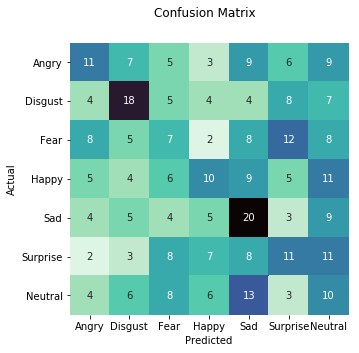

In [12]:
params = {'iid': True,
          'n_estimators': 50,
          'max_depth': 10}

param_grid = {'n_estimators': [50, 200, 300],
             'max_depth': [10, 20, 30]}

# Initialize and fit the model
rfc = RandomForestClassifier(random_state=42)
grid_rfc = GridSearchCV(rfc, param_grid, return_train_score=False, n_jobs=-1, cv=3)
grid_rfc.fit(X_train, y_train)

# Print results
y_pred = grid_rfc.predict(X_valid)
print_results(grid_rfc, X_train, X_valid, y_pred)

# Save score
rfc1_score = grid_rfc.score(X_valid, y_valid)

Well, this is obvious bad. We were extecting this. Random forest is not the right model to use in this case, but we will be running them for comparison and learning proposes.

#### Gradient Boosting

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.23
Validation set score:		 0.26
              precision    recall  f1-score   support

           0       0.31      0.30      0.30        50
           1       0.43      0.36      0.39        50
           2       0.11      0.12      0.12        50
           3       0.30      0.26      0.28        50
           4       0.20      0.20      0.20        50
           5       0.34      0.34      0.34        50
           6       0.18      0.22      0.20        50

   micro avg       0.26      0.26      0.26       350
   macro avg       0.27      0.26      0.26       350
weighted avg       0.27      0.26      0.26       350



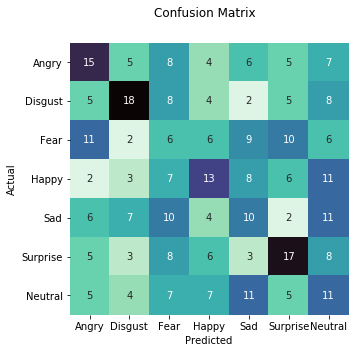

In [18]:
params = {'n_estimators': 100,
          'max_depth': 5,
          'learning_rate': 0.1,
          'loss': 'exponential'}

param_grid = {'n_estimators': [100 , 200, 300],
             'max_depth': [5, 10]}

# Initialize and fit the model
gbc = GradientBoostingClassifier(random_state=42)
grid_gbc = GridSearchCV(gbc, param_grid, return_train_score=False, n_jobs=-1, cv=3)
grid_gbc.fit(X_train, y_train)

# Print results 
y_pred = grid_gbc.predict(X_valid)
print_results(grid_gbc, X_train, X_valid, y_pred)

# Save score
gbc1_score = grid_gbc.score(X_valid, y_valid)

This one is even worse. Overfitting and bad predictions...

#### SVC

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 0.95
Best cross validation score:	 0.22
Validation set score:		 0.25
              precision    recall  f1-score   support

           0       0.15      0.12      0.13        50
           1       0.35      0.38      0.36        50
           2       0.30      0.28      0.29        50
           3       0.24      0.26      0.25        50
           4       0.17      0.22      0.19        50
           5       0.33      0.32      0.32        50
           6       0.23      0.20      0.21        50

   micro avg       0.25      0.25      0.25       350
   macro avg       0.25      0.25      0.25       350
weighted avg       0.25      0.25      0.25       350



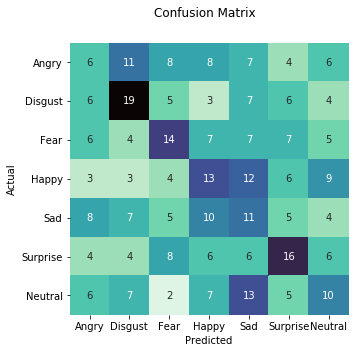

In [19]:
params = {'gamma': 'auto',
          'kernel': 'linear',
           'C': 100}

param_grid = {'C': [.1, 1, 10]}

# Initialize and fit the model
svc = SVC(**params, random_state=42)
grid_svc = GridSearchCV(svc, param_grid, return_train_score=False, n_jobs=-1, cv=3)
grid_svc.fit(X_train, y_train)

# Print Results
y_pred = grid_svc.predict(X_valid)
print_results(grid_svc, X_train, X_valid, y_pred)

# Save score
svc1_score = grid_svc.score(X_valid, y_valid)

Again, pretty bad.

Next, we are going to create features and see if our accuracies increase or decrease.

### *PCA*

A way of creating features from our images is to generate Eigen Faces. It simply consist on applyimg Principal Component Analysis (PCA) to our pictures. Before applying PCA we should align the eyes and mouths in every picture. We are not going to do this because our pictures are pretty aligned. Also, in this first part of the capstone, we are not focused on the results, but on learning how to work with images and extract features.

Let's perform PCA for 300 components.

If we represent the mean of all the components, we get a sort of mean face (extrictely speaking, mean face would be the mean of all the images in the dataset).

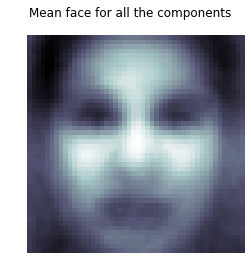

In [20]:
#Perform PCA
pca = decomposition.PCA(n_components=300)
pca.fit(X_train)

# Plot mean face
plt.imshow(pca.mean_.reshape(48,48),cmap=plt.cm.bone)
plt.suptitle('Mean face for all the components')
plt.axis('off')
plt.show()

This is pretty cool. It definetely reminds us of a face. 

Let's take a look of some of the Eigen Faces

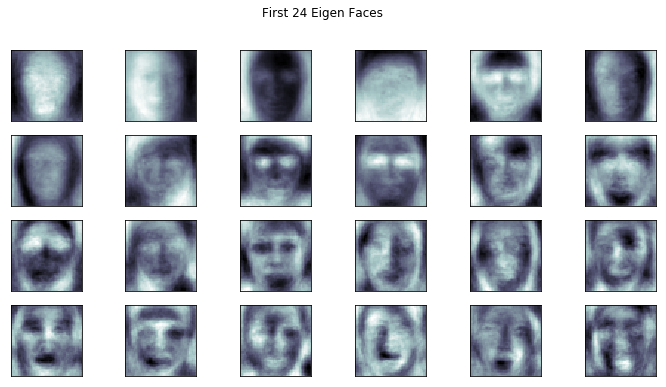

In [21]:
# Plot Eigen Faces
Eigenfaces = pca.components_[0:24]
fig = plt.figure(figsize=(12, 6))

for i in range(24):
    plt.subplot(4, 6, i + 1, xticks=[], yticks=[])
    plt.imshow(Eigenfaces[i].reshape(48,48), cmap=plt.cm.bone)

fig.suptitle('First 24 Eigen Faces')
plt.show()

A great way of visualizing the Eigen Faces is to see how they change the mean face when we vary the weight of one component.  

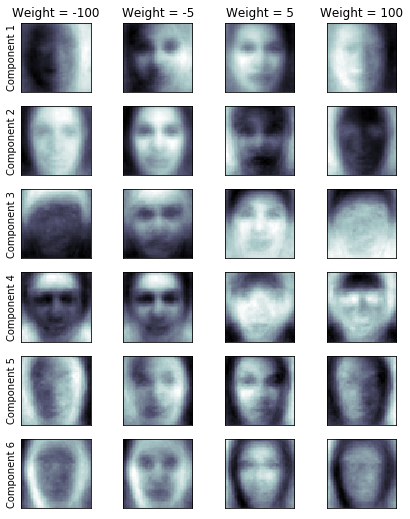

In [22]:
# Plot mean face changing the weight of one component at a time
fig = plt.figure(figsize=(7, 12))
weights = [-100, -5, 5, 100]
n = 1
for j in range(1, 7):
    for i in range(len(weights)):
        ax = plt.subplot(8,4,n, xticks=[], yticks=[])
        if n in range(1,5):
            ax.title.set_text('Weight = '+ str(weights[i]))
        if n in range(1,36,4):
            ax.set_ylabel('Component '+ str(j))
        plt.imshow(np.add(pca.mean_.reshape(48,48), (Eigenfaces[j].reshape(48,48)) * weights[i]) 
                   ,cmap=plt.cm.bone)
        n += 1

The first components detect the skin tone and the next lighting effects: top, bottom, sides, corner...

The following components start focusing on features: eyes, smiles, frowns...

In the following chart, we can see the amount of variance explained by the corresponding number of components.

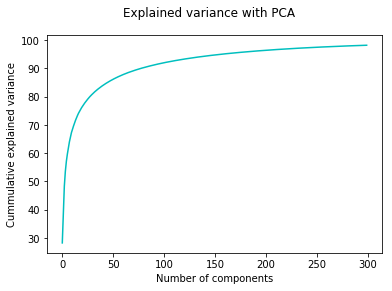

In [23]:
# Plot change of explained variance with #components 
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100., color='c')
plt.xlabel('Number of components')
plt.ylabel('Cummulative explained variance')
plt.suptitle('Explained variance with PCA')
plt.show()

If we keep 150 components, we get over 90% of the variance. 

Let's now transform X_train and X_valid.

In [24]:
# Transform sets
X_train_pca = pca.transform(X_train)[:,:150]
X_valid_pca = pca.transform(X_valid)[:,:150]

#### PCA and Random Forest

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.24
Validation set score:		 0.23
              precision    recall  f1-score   support

           0       0.30      0.14      0.19        50
           1       0.31      0.34      0.33        50
           2       0.16      0.14      0.15        50
           3       0.22      0.28      0.24        50
           4       0.23      0.28      0.25        50
           5       0.31      0.30      0.31        50
           6       0.11      0.12      0.12        50

   micro avg       0.23      0.23      0.23       350
   macro avg       0.23      0.23      0.23       350
weighted avg       0.23      0.23      0.23       350



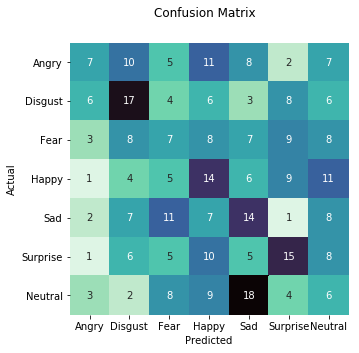

In [25]:
grid_rfc.fit(X_train_pca, y_train)
y_pred = grid_rfc.predict(X_valid_pca)
print_results(grid_rfc, X_train_pca, X_valid_pca, y_pred)

# Save score
rfc2_score = grid_rfc.score(X_valid_pca, y_valid)

#### PCA and Gradient Boosting

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.21
Validation set score:		 0.24
              precision    recall  f1-score   support

           0       0.29      0.16      0.21        50
           1       0.26      0.26      0.26        50
           2       0.16      0.18      0.17        50
           3       0.26      0.34      0.30        50
           4       0.17      0.22      0.19        50
           5       0.31      0.30      0.31        50
           6       0.26      0.20      0.22        50

   micro avg       0.24      0.24      0.24       350
   macro avg       0.24      0.24      0.24       350
weighted avg       0.24      0.24      0.24       350



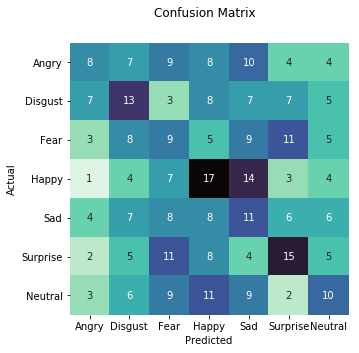

In [26]:
grid_gbc.fit(X_train_pca, y_train)
y_pred = grid_gbc.predict(X_valid_pca)
print_results(grid_gbc, X_train_pca, X_valid_pca, y_pred)

# Save score
gbc2_score = grid_rfc.score(X_valid_pca, y_valid)

#### PCA and SVC

Train set score:		 0.71
Best cross validation score:	 0.24
Validation set score:		 0.26
              precision    recall  f1-score   support

           0       0.16      0.12      0.14        50
           1       0.35      0.38      0.37        50
           2       0.32      0.28      0.30        50
           3       0.19      0.24      0.21        50
           4       0.22      0.30      0.26        50
           5       0.33      0.32      0.32        50
           6       0.22      0.16      0.18        50

   micro avg       0.26      0.26      0.26       350
   macro avg       0.26      0.26      0.25       350
weighted avg       0.26      0.26      0.25       350



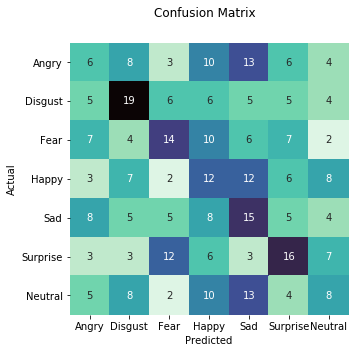

In [27]:
grid_svc.fit(X_train_pca, y_train)
y_pred = grid_svc.predict(X_valid_pca)
print_results(grid_svc, X_train_pca, X_valid_pca, y_pred)

# Save score
svc2_score = grid_svc.score(X_valid_pca, y_valid)

### *Local Binary Patterns*

Another technique to extract features is Local binary patterns (LBP). In this capstone, we will use LBP to filter the features of facial textures.

LBP transforms image blocks into an array of labels. Such labels (or their statistics, for example histograms) are used as features.

In the basic version of the LBP (the one we will be using), we consider the values of a 3x3 pixel neighborhood. For each pixel in a cell, compare the pixel to each of its 8 neighbors (on its left-top, left-middle, left-bottom, right-top, etc.). Follow the pixels along a circle, i.e. clockwise or counter-clockwise. Where the center pixel's value is greater than the neighbor's value, write "0". Otherwise, write "1". This gives an 8-digit binary number (which is usually converted to decimal for convenience).

In [28]:
def lbp(img):
    patterns = []
    pixels = img
    width = 48
    height = 48
    pixels = [pixels[i * width:(i + 1) * width] for i in range(height)]

    # Calculate LBP for each non-edge pixel
    for i in range(1, height - 1):
        # Cache only the rows we need (within the neighborhood)
        previous_row = pixels[i - 1]
        current_row = pixels[i]
        next_row = pixels[i + 1]

        for j in range(1, width - 1):
            # Compare this pixel to its neighbors, starting at the top-left pixel and moving
            # clockwise, and use bit operations to efficiently update the feature vector
            pixel = current_row[j]
            pattern = 0
            pattern = pattern | (1 << 0) if pixel < previous_row[j-1] else pattern
            pattern = pattern | (1 << 1) if pixel < previous_row[j] else pattern
            pattern = pattern | (1 << 2) if pixel < previous_row[j+1] else pattern
            pattern = pattern | (1 << 3) if pixel < current_row[j+1] else pattern
            pattern = pattern | (1 << 4) if pixel < next_row[j+1] else pattern
            pattern = pattern | (1 << 5) if pixel < next_row[j] else pattern
            pattern = pattern | (1 << 6) if pixel < next_row[j-1] else pattern
            pattern = pattern | (1 << 7) if pixel < current_row[j-1] else pattern

            patterns.append(pattern)

    return patterns

We can see now the some examples of the images transformed by LBP.

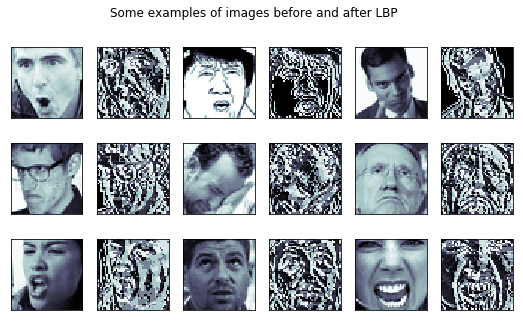

In [29]:
# Transform X_train 
X_train_lbp = pd.DataFrame()
for i in range(len(X_train)):
    X_train_lbp[i] = np.array(lbp(X_train[i]))

# Plot examples
plt.figure(figsize=(9,5))
plt.suptitle('Some examples of images before and after LBP')
for i in range(1,18,2):
    plt.subplot(3,6,i, xticks=[], yticks=[])
    plt.imshow(X_train[i].reshape(48,48), cmap=plt.cm.bone)
    plt.subplot(3,6,i+1, xticks=[], yticks=[])
    plt.imshow(np.array(X_train_lbp[i]).reshape(46,46), cmap=plt.cm.bone)


We can now transform X_valid to run our models.

In [30]:
# Transform X_valid
X_valid_lbp = pd.DataFrame()
for i in range(len(X_valid)):
    X_valid_lbp[i] = np.array(lbp(X_valid[i]))

#### LBP and Random Forest

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.21
Validation set score:		 0.18
              precision    recall  f1-score   support

           0       0.12      0.12      0.12        50
           1       0.25      0.28      0.27        50
           2       0.18      0.16      0.17        50
           3       0.15      0.16      0.16        50
           4       0.15      0.16      0.16        50
           5       0.19      0.12      0.15        50
           6       0.19      0.24      0.21        50

   micro avg       0.18      0.18      0.18       350
   macro avg       0.18      0.18      0.18       350
weighted avg       0.18      0.18      0.18       350



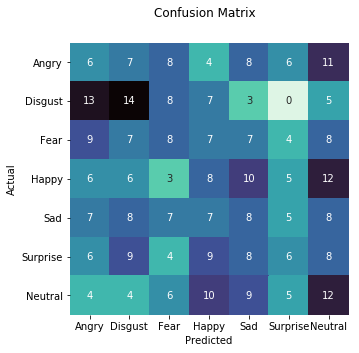

In [31]:
grid_rfc.fit(X_train_lbp.T, y_train)
y_pred = grid_rfc.predict(X_valid_lbp.T)
print_results(grid_rfc, X_train_lbp.T, X_valid_lbp.T, y_pred)

# Save score
rfc3_score = grid_rfc.score(X_valid_lbp.T, y_valid)

#### LBP and Gradient Boosting

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.19
Validation set score:		 0.19
              precision    recall  f1-score   support

           0       0.15      0.18      0.16        50
           1       0.25      0.20      0.22        50
           2       0.26      0.22      0.24        50
           3       0.19      0.22      0.20        50
           4       0.07      0.06      0.06        50
           5       0.20      0.20      0.20        50
           6       0.22      0.24      0.23        50

   micro avg       0.19      0.19      0.19       350
   macro avg       0.19      0.19      0.19       350
weighted avg       0.19      0.19      0.19       350



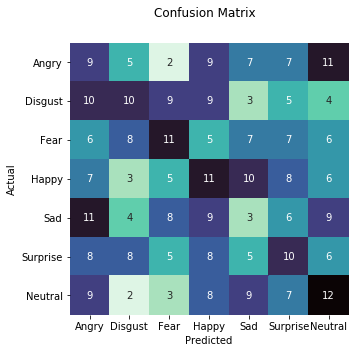

In [32]:
grid_gbc.fit(X_train_lbp.T, y_train)
y_pred = grid_gbc.predict(X_valid_lbp.T)
print_results(grid_gbc, X_train_lbp.T, X_valid_lbp.T, y_pred)

# Save score
gbc3_score = grid_gbc.score(X_valid_lbp.T, y_valid)

#### LBP and SVC

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Train set score:		 1.0
Best cross validation score:	 0.19
Validation set score:		 0.21
              precision    recall  f1-score   support

           0       0.20      0.24      0.22        50
           1       0.26      0.24      0.25        50
           2       0.21      0.18      0.20        50
           3       0.26      0.28      0.27        50
           4       0.14      0.14      0.14        50
           5       0.21      0.24      0.23        50
           6       0.21      0.18      0.19        50

   micro avg       0.21      0.21      0.21       350
   macro avg       0.21      0.21      0.21       350
weighted avg       0.21      0.21      0.21       350



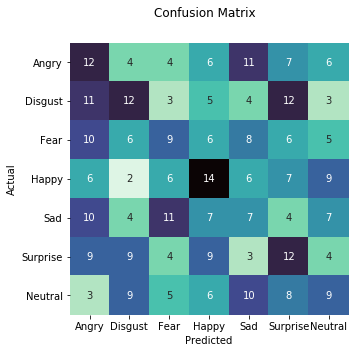

In [33]:
grid_svc.fit(X_train_lbp.T, y_train)
y_pred = grid_svc.predict(X_valid_lbp.T)
print_results(grid_svc, X_train_lbp.T, X_valid_lbp.T, y_pred)

# Save score
svc3_score = grid_svc.score(X_valid_lbp.T, y_valid)

### *Model Comparison*

In [34]:
print('\t Random Forest\tGradient Boosting\tSVC')
print(f'\t\t{round(rfc1_score,2)}\t\t{round(gbc1_score,2)}\t\t{round(svc1_score,2)}\t\t')
print(f'PCA\t\t{round(rfc2_score,2)}\t\t{round(gbc2_score,2)}\t\t{round(svc2_score,2)}\t\t')
print(f'LBP\t\t{round(rfc3_score,2)}\t\t{round(gbc3_score,2)}\t\t{round(svc3_score,2)}\t\t')

	 Random Forest	Gradient Boosting	SVC
		0.25		0.26		0.25		
PCA		0.23		0.23		0.26		
LBP		0.18		0.19		0.21		


All the models ovefitted greatly and had low accuracy, which was expected, since these models are not good with images. In the next part, we will use Convolutional Neural Networks (CNNs), which are the right tool to use when working with image classification.

The best models were vanilla gradient boosting and SVC after PCA. We could try to use that model to separate only two categories, instead of 7. It'd probably performs much better. But, for the moment, let's put that in the bucket list and focus on CNNs.

## 4. Convolutional Neural Networks

### *Data Augmentation*

Data augmentation is a technique used to virtually create more instances of the pictures. Every time the CNN grabs an image, it will be slightly different. For humans, they will look the same pictures, but for the computer it is like a brand new one. This helps fighting class imbalance.

The transformations will slightly change:
* Rotation
* Zoom
* Lighting
* Warp
* Padding

The pictures may also be flipped horizontaly.

These are some examples of the same picture after the transformations are applied:

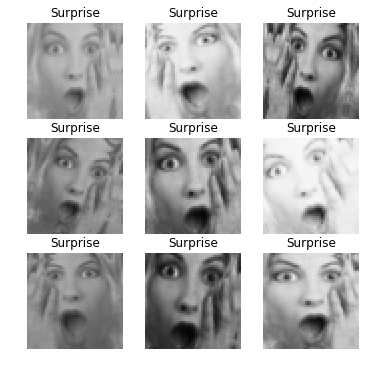

In [35]:
# Visualize data augmentation
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)
plot_multi(_plot, 3, 3, figsize=(6,6))

### *Pretrained models*

Transfer learning is a popular method in computer vision because it allows us to build accurate models in a timesaving way. Instead of starting the learning process from scratch, we can start from patterns that have been learned when solving a different problem. 

In computer vision, transfer learning is usually expressed through the use of pre-trained models. A pre-trained model is a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve. 



#### **VGG-19**:

Let's try VGG-19, that has been succesfully use for facial and emotion recognition in the past. 

VGG-19 is a convolutional neural network created by Visual Geometry Group of the Department of Engineering Science, University of Oxford. It has been trained on more than a million images from the ImageNet database. The network is 19 layers deep and can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. Below, we can see the network structure. We will talk a little more about the part of a CNN in the next section.

![](https://www.researchgate.net/profile/Clifford_Yang/publication/325137356/figure/fig2/AS:670371271413777@1536840374533/llustration-of-the-network-architecture-of-VGG-19-model-conv-means-convolution-FC-means_W640.jpg)

In [36]:
# Load model
np.random.seed(42)
learn = cnn_learner(data, models.vgg19_bn, metrics=accuracy, model_dir='/tmp/model/', pretrained=True) 

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /tmp/.torch/models/vgg19_bn-c79401a0.pth
574769405it [00:37, 15341859.46it/s]


Let's train! Since our model was previously trained, we are only going to train last layers for our particular dataset.

In [37]:
learn.fit_one_cycle(10) 

epoch,train_loss,valid_loss,accuracy,time
0,2.031121,1.722820,0.323463,01:09
1,1.781356,1.634870,0.347326,00:44
2,1.680146,1.581221,0.383557,00:44
3,1.587758,1.540498,0.398014,00:46
4,1.530414,1.455001,0.438425,00:45
5,1.482565,1.413634,0.449747,00:45
6,1.450789,1.386042,0.465424,00:44
7,1.430052,1.375331,0.474133,00:46
8,1.411129,1.366983,0.479011,00:43
9,1.410502,1.369845,0.477791,00:44


For fine tunning, we are going to adjust the learning rate and run again for some more epochs. To do that, we unfreeze, this will train the entire network.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


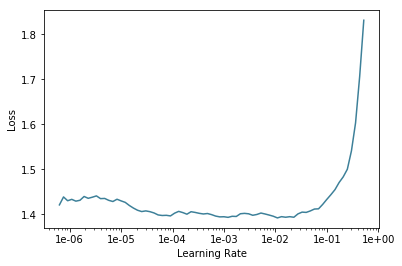

In [38]:
learn.lr_find()

# Change palette
current_palette = sns.color_palette('GnBu_d',2)
sns.set_palette(current_palette)

# Plot lr finder
learn.recorder.plot()

In [39]:
# Function to plot the evolution of train and valid accuracy with number of epochs
def plot_losses_epochs (learner, epochs):
    plt.figure(figsize=(7,5))
    plt.plot(list(range(epochs)),learner.recorder.val_losses, label='Validation loss')
    plt.plot(list(range(epochs)),[learner.recorder.losses[i] for i in range(bs-1,bs*epochs,bs)], label='Training loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

We can choose two maximun learning rates. For the last layers, we can choose a bigger rate. For the first layers, however, we want to make sure to choose it small, way before the loss starts growing. For the intermediate layers, the learning rate will be distributed between the two given values.

In [40]:
learn.unfreeze()
epochs = 22
np.random.seed(42)
learn.fit_one_cycle(epochs, max_lr=slice(1e-3, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,1.215372,1.147863,0.562794,00:47
1,1.169737,1.200008,0.550078,00:45
2,1.179007,1.237502,0.543808,00:47
3,1.180250,1.304364,0.547988,00:48
4,1.198163,1.256540,0.554956,00:45
5,1.173658,1.242009,0.553388,00:48
6,1.140679,1.152339,0.588225,00:45
7,1.122158,1.162127,0.583348,00:48
8,1.085574,1.025113,0.623933,00:46
9,1.037924,1.050810,0.614179,00:47


In [41]:
train_acc = learn.validate(learn.data.train_dl)
valid_acc = learn.validate(learn.data.valid_dl)
print('Training Accuracy:\t',round(float(train_acc[1]),4))
print('Validation Accuracy:\t',round(float(valid_acc[1]),4))

Training Accuracy:	 0.7537
Validation Accuracy:	 0.6879


We get around 69% accuracy, the same result as the Kaggle Competition winner. However, we have to say that CNN have evolved a lot within the last years and this an old challenge (from 6 years ago), so this was totally expected.

And now we can look at the evolution of our losses.

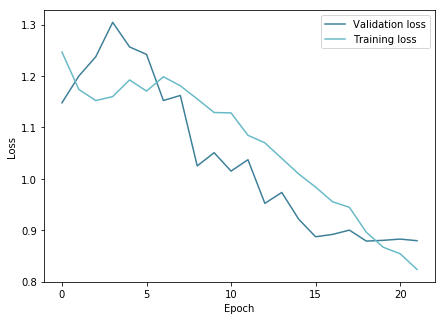

In [42]:
plot_losses_epochs(learn, epochs=epochs)

* As we can see, it started overfitting towards the end. However, the validation accuracy was still increasing. We stopped running right before the accuracy started decreasing.

Let's see some predictions:

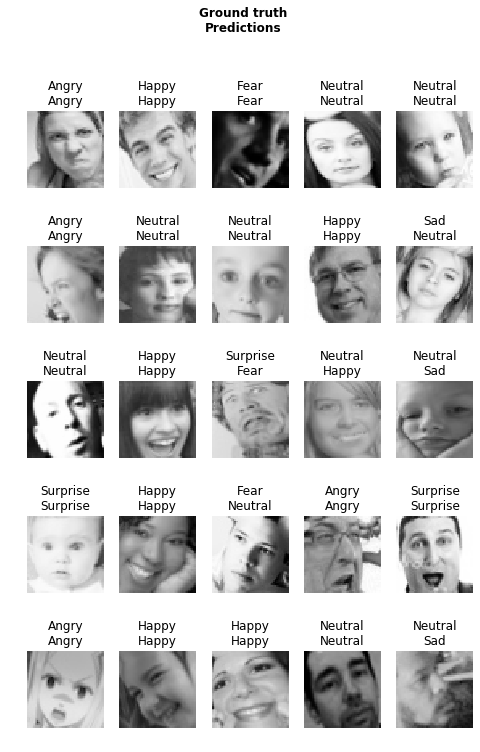

In [47]:
learn.show_results(ds_type=DatasetType.Train, figsize=(8,12))

Let's take a look on the results in the confusion matrix.

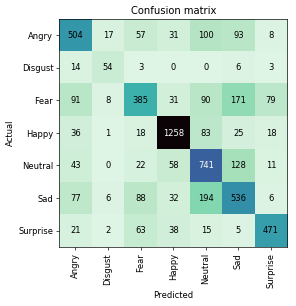

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5), dpi=60, cmap='mako_r')

It looks like data augmentation helped fighting the class imbalance. In previous versions of this notebook, we weren't using that technique and the class 'Disgust' wasn't being predicted well.

We can see were our maximum losses were in order to understand why the model was wrong.

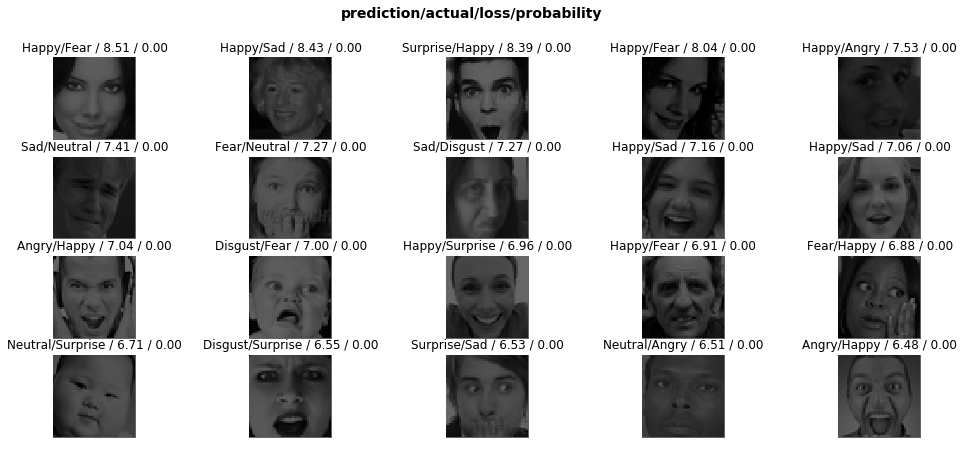

In [45]:
losses,idxs = interp.top_losses()
interp.plot_top_losses(20, figsize=(17,7))

Some of these are misinterpretations by the model, but most of them are wrong labels. So the model is not too bad after all! 

Let's see in what categories are we getting the bigger amount of errors.

In [46]:
interp.most_confused(min_val=90)

[('Sad', 'Neutral', 194),
 ('Fear', 'Sad', 171),
 ('Neutral', 'Sad', 128),
 ('Angry', 'Neutral', 100),
 ('Angry', 'Sad', 93),
 ('Fear', 'Angry', 91),
 ('Fear', 'Neutral', 90)]

It looks like the biggest challenge for the model is to distinguish between neutral and sad, followed by fear and sad. 

#### **Cleaning the data?**

Facial expression recognition can be tricky because it is often subjective. However, looking at the top losses, we can see that some labels are not quite right. With fastai we can delete or re-label those images from the model to increase our accuracy. 

In our case, we are NOT going to do it. Even if we only re-label the validation set, we would need to manually label a big amount of images.

Moreover, we could go and sort of cheat, re-labeling every single image to match the prediction. So, what's the point?

### *CNN from Scratch*

To create our own CNN from scratch, we've decide to use residual blocks (or res-blocks), similar to what RESNET does. But first let's explain briefly the parts that compose it:

#### **Convolutions**

Each of our images is a 3D matrix or, as pytorch call them, rank 3 tensor. 

Convolution is a mathematical operation to merge two sets of information. In our case the convolution is applied on the input data using a convolution filter (or kernel) to produce a feature map. 
![](https://i.stack.imgur.com/YDusp.png) 
                                Source: https://i.stack.imgur.com

#### **Stride**
Stride specifies how much we move the convolution filter at each step. By default the value is 1.

We can have bigger strides if we want less overlap between the receptive fields. This also makes the resulting feature map smaller since we are skipping over potential locations. 

#### **Padding**
After a convolution stride 1 the size of the feature map is smaller than the input, because the convolution filter needs to be contained in the input. If we want to maintain the same dimensionality, we can use padding to surround the input with zeros or other values. We will use reflexion.

#### **RELU Activation**
For neural network to be powerful, it needs to contain non-linearity. After a convolution, we pass the result through Rectified Linear Units (RELU) activation function. The result is the maximun between the value and zero. 

#### **Pooling**
After a convolution operation we can perform pooling to reduce the dimensionality. This enables us to reduce the number of parameters, which both shortens the training time and combats overfitting. Pooling layers downsample each feature map independently, reducing the height and width, keeping the depth intact.

The most common type of pooling, and the one we will use, is max pooling which just takes the max value in the pooling window. Contrary to the convolution operation, pooling has no parameters..

#### **Batch Normalization**
In batch normalization, we simpply normalize the values in the hidden layers, that are changing all the time. We can 10 times or more improvement in the training speed and reduce overfitting.

#### **Residual Blocks**
In a network with residual blocks, each layer feeds into the next layer and directly into the layers about 2–3 hops away. This is the way RESNET, a state of the art CNN, is coded.

![](https://cdn-images-1.medium.com/max/1200/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

Source: https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-andresnext-for-state-of-the-art-image-cf51669e1624


Let's define our CNN:

In [48]:
# Define res-blocks and convolutions
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [49]:
# create network
model_own = nn.Sequential(
    conv_and_res(3, 8), #24
    conv_and_res(8, 16),#12
    conv_and_res(16, 32),#6
    conv_and_res(32, 64),#3
    conv2(64, 128),#2
    nn.MaxPool2d(2,2),
    conv2(128, 256),#1
    Flatten(),
    nn.Linear(256,128),
    nn.Dropout(.5),
    nn.Linear(128,7))

In [50]:
# Define learner
learn_own = Learner(data, model_own, loss_func = nn.CrossEntropyLoss(), metrics=accuracy, model_dir='/tmp/model/')
print(learn_own.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 24, 24]          216        True      
______________________________________________________________________
ReLU                 [8, 24, 24]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 24, 24]          16         True      
______________________________________________________________________
Conv2d               [8, 24, 24]          576        True      
______________________________________________________________________
ReLU                 [8, 24, 24]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 24, 24]          16         True      
______________________________________________________________________
Conv2d               [8, 24, 24]          576        True      
______________________________________________________________

The typical CNN architecture is a sequence of convolutional blocks, with certain degree of stride beween then. Thus, the image size decreases as the network gets deeper. The convolutional part is responsible for feature extraction.

We then often place fully connected layers, that are in charge of the classification.

![](https://i.udemycdn.com/course/240x135/1981490_f021_2.jpg)
Source: https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2

In out network, we have 16 layers, 14 convolutional and 2 fully connected. Let's train our new model:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


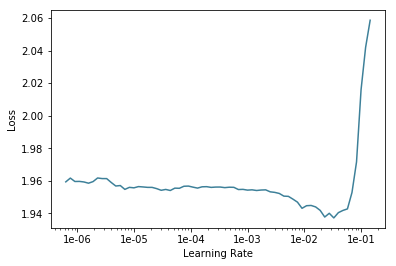

In [51]:
learn_own.lr_find()
learn_own.recorder.plot()

In [52]:
np.random.seed(42)
epochs = 37
learn_own.fit_one_cycle(epochs, max_lr=1e-2) 

epoch,train_loss,valid_loss,accuracy,time
0,1.833340,1.777393,0.260756,00:44
1,1.786614,1.741074,0.277304,00:43
2,1.739925,1.664276,0.334088,00:44
3,1.690187,1.631480,0.362132,00:44
4,1.635692,1.572168,0.388086,00:46
5,1.594738,1.513040,0.405504,00:43
6,1.539724,1.493515,0.423445,00:44
7,1.496700,1.444816,0.453405,00:44
8,1.464034,1.405659,0.457586,00:43
9,1.442634,1.362169,0.480578,00:44


In [53]:
train_acc = learn_own.validate(learn.data.train_dl)
valid_acc = learn_own.validate(learn.data.valid_dl)
print('Training Accuracy:\t',round(float(train_acc[1]),4))
print('Validation Accuracy:\t',round(float(valid_acc[1]),4))

Training Accuracy:	 0.6037
Validation Accuracy:	 0.5941


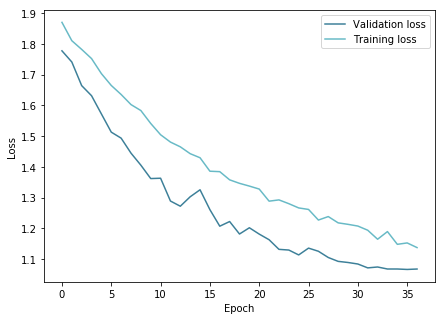

In [54]:
plot_losses_epochs(learn_own, epochs=epochs)

We got about a 60% accuracy. Not bad for doing it from scratch. We could play with some parameters (kernel size, number of layers, pooling, loss function, dropout, optimizer, etc etc etc) to increase accuracy.

### *CNN Features*

One of the great parts about Neural Networks is that they create features on their own. So let's see what happens inside the convolutions and how the features are created. To do that, we need to create what fastai calls a hook that will save the output after every block.

In [55]:
# Grab a picture
m = learn_own.model.eval()
x,y = data.train_ds[0]
xb,_ = data.one_item(x)

In [56]:
# Create a hook and save weights
def hooked_backward(y, i):
    with hook_output(m[i]) as hook_a: 
        with hook_output(m[i], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()
    return hook_a,hook_g

Let's take a look of our one of our images after each block. Remember that we are doing a stride 2, that's why the image gets smaller. In exchange, we get more channels (the network gets deeper).

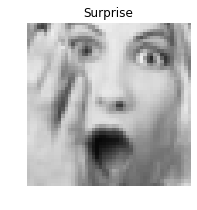

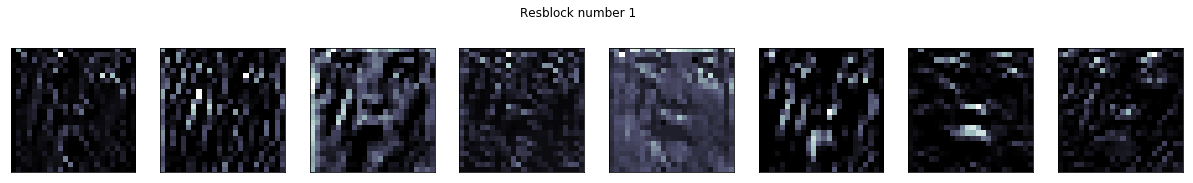

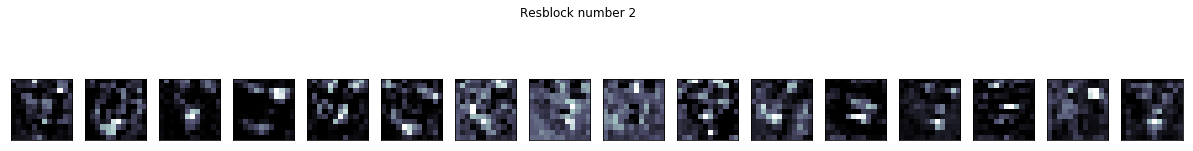

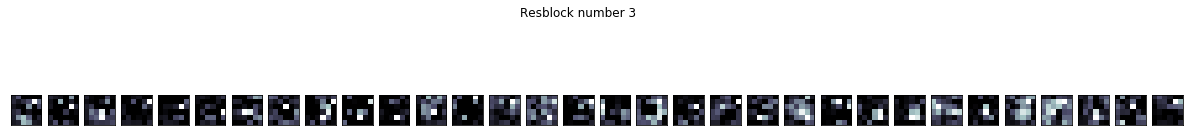

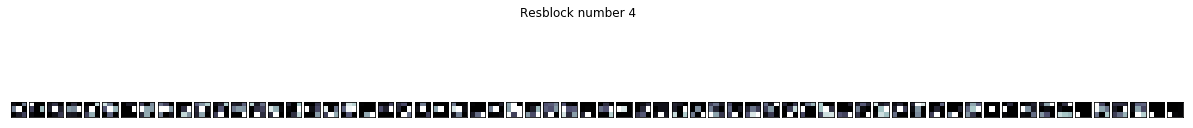

In [57]:
x.show(y=y)
for i in range(4):
    fig = plt.figure(figsize=(21,3))
    fig.suptitle('Resblock number ' + str(i+1))
    hook_a,hook_g = hooked_backward(y, i)
    acts  = hook_a.stored[0]
    for j in range(len(acts)):
        plt.subplot(1,len(acts),j+1, xticks=[], yticks=[],)
        plt.imshow(acts[j], cmap=plt.cm.bone)
plt.show()

Because our images are small (48x48 pixels), the visualizations are not as cool as the ones that can be found online. And also because of small size, after the 3rd block we cannot see much. 

That being said, we can see how the images are simplified to just extract the features that we want. In the 1st row in the charch we are detecting the edges, and in the 2nd row we can see how the network locates months and eyes, isolating them from the rest of the face. Cool, isn't it?

## 5. Saving the Model

So we have our model, let's see it in action, how it would work in production. We can export it and use to use in in production.

In [58]:
learn_own.export(wd+'/export_own.pkl')
learn.export(wd+'/export.pkl')

#Use the bellow code to run in CPU
#learn_own = load_learner(wd)
#learn = load_learner(wd)

Let's see how it predicts our test set:

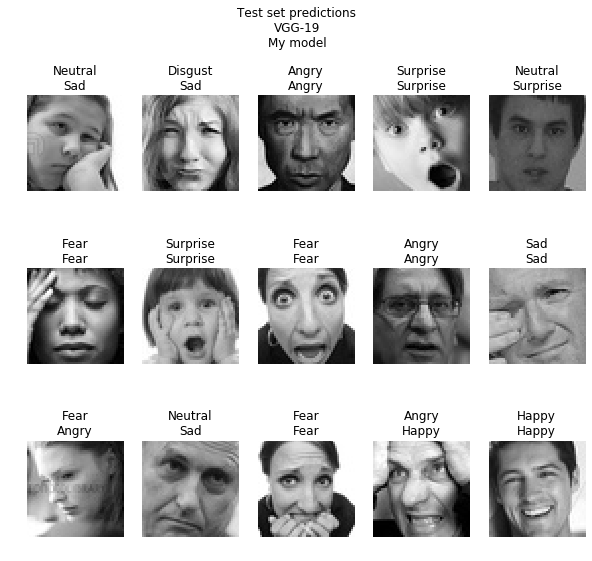

In [59]:
rand_list = random.sample(range(len(data.test_ds)), 15)
plt.figure(figsize=(10,9))
for r in rand_list:
    img = data.test_ds.x[r]
    pred_class1 = learn.predict(img)[0]
    pred_class2 = learn_own.predict(img)[0]
    ax = plt.subplot(3, 5, rand_list.index(r)+1)
    img.show(ax=ax, title = (str(pred_class1)+'\n'+str(pred_class2)))

plt.suptitle('Test set predictions\nVGG-19\nMy model')
plt.show()

Not bad. Some images are pretty confusing to me. I think it's doing a better job that I'd do.

It seems to have issues with .

And now, will it predict correctly other pictures? Here are some pictures of my family. Let's see the model in action:

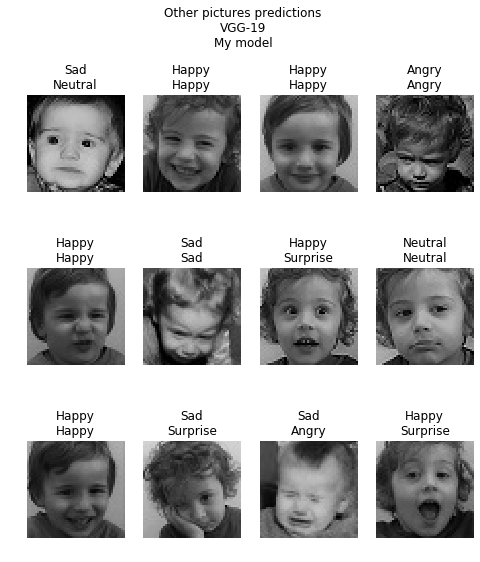

In [60]:
path3 =  '../input/emotions/'
os.listdir(path3)
file_list = os.listdir(path3)
random.shuffle(file_list)

plt.figure(figsize=(8,9))
for f in file_list[:12]:
    img = open_image(path3+f)
    pred_class1 = learn.predict(img)[0]
    pred_class2 = learn_own.predict(img)[0]
    ax = plt.subplot(3, 4, file_list.index(f)+1)
    img.show(ax = ax, title=(str(pred_class1)+'\n'+str(pred_class2)))
    
plt.suptitle('Other pictures predictions\nVGG-19\nMy model\n')
plt.show()

## 6. Conclussions

* We were able to succesfully extract the image features with unsupervised learning techniques. However, the classic supervised learning classification models performed poorly.

* Pre-trained CNN models performed pretty well and fast (low number of epochs). We were able to classify emotions with 69% accuracy.

* We were able to create a CNN from scratch that performed pretty well, with an accuracy over 60%. However, the training process was longer, needing more epochs to achieve the aforementioned accuracy.

## 7. Future work

 

To improve this capstone we can:

* Use other datasets with better labels and higher image resolution.
* In the pre-trained models, we can introduce weights obtained training facial features of other datasets (e.g. VGG-Face that works with VGG-16).
* Improve our own model: changing achitecture and tuning hyperparameters.
* Use the model to predict facial emotions in videos.

## 8. References
* https://www.fast.ai/
* http://www.robots.ox.ac.uk/~vgg/
* https://arxiv.org/abs/1512.03385
* https://towardsdatascience.com/applied-deep-learning-part-4-convolutional-neural-networks-584bc134c1e2
* https://towardsdatascience.com/batch-normalization-in-neural-networks-1ac91516821c